# Tutorial 1. The Measurement Control 

This tutorial covers basic usage of quantify focusing on running basic experiments using `MeasurementControl`. 
The `MeasurementControl` is the main `Instrument` in charge of running any experiment. It takes care of saving the data in a standardized format as well as live plotting of the data during the experiment. 
`quantify` makes a distinction between `soft`(ware) controlled measurements and `hard`(ware) controlled measurements. 

In a `soft` measurement `MeasurementControl` is in charge of the measurement loop and consecutively sets and gets datapoints. A `soft` measurement can be 1D, 2D or higher dimensional and also supports adaptive measurements in which the datapoints are determined during the measurement loop. 

In a `hard` measurement the hardware (such as an AWG or a central controller) is in charge of the measurement loop. In this case, the datapoints to be acquired are determined before the experiment starts and are precompiled into the hardware which is then armed and starts acquisition. In a `hard` measurement `MeasurementControl` does not take care of the measurement loop but still takes care of the data storage and live plotting of the experiment. 

In [12]:
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
from qcodes import ManualParameter, Parameter
%matplotlib inline

In [6]:
from quantify.measurement import MeasurementControl


In [7]:
MC = MeasurementControl('MC')

KeyError: 'Another instrument has the name: MC'

In [8]:
MC._setables

[]

In [9]:
p0 = ManualParameter('p0')

In [10]:
p0.unit

''

In [11]:
def cos_po():
    return np.cos(p0())

In [13]:
p1 = Parameter('p1', get_cmd=cos_po)

In [15]:
MC.setables(p0)

In [16]:
MC.getables(p1)

In [17]:
MC.run()

In [19]:
x0 = np.linspace(0, 30)

In [20]:
y0 = []
for x in x0: 
    p0(x)
    y0.append(p1())

In [31]:
from quantify.measurement.data_handling import gen_tuid

In [64]:
snap = MC.snapshot()
exclude_keys = {
    "inter_delay",
    "post_delay",
    "vals",
    "instrument",
    "functions",
    "__class__",
    "ts",
    "raw_value",
    "instrument_name",
    "full_name",
    "val_mapping",
}
cleaned_snapshot = delete_keys_from_dict(snap, exclude_keys)

In [62]:
x0r = xr.DataArray(x0, name=p0.name, attrs={'label':p0.label, 'unit':p0.unit})
y0r = xr.DataArray(y0, name=p1.name, attrs={'label':p1.label, 'unit':p1.unit})

dset = xr.Dataset({'x0': x0r, 'y0':y0r}, attrs={'tuid': gen_tuid(), 'snapshot': cleaned_snapshot})

In [63]:
dset.to_netcdf('test.hdf5')

TypeError: Invalid value for attr: {'submodules': {}, 'parameters': {'IDN': {'value': None, 'ts': None, 'label': 'IDN', 'unit': '', 'name': 'IDN'}, 'datadir': {'value': '', 'ts': '2020-04-24 23:07:16', 'label': 'datadir', 'unit': '', 'name': 'datadir'}, 'setables': {'value': <qcodes.instrument.parameter.ManualParameter: p0 at 4848886864>, 'ts': '2020-04-24 23:09:05', 'label': 'setables', 'unit': '', 'name': 'setables'}, 'getables': {'value': <function cos_po at 0x12127c050>, 'ts': '2020-04-24 23:31:06', 'label': 'getables', 'unit': '', 'name': 'getables'}}, 'name': 'MC'} must be a number, a string, an ndarray or a list/tuple of numbers/strings for serialization to netCDF files

In [45]:
new_dset = xr.open_dataset('test.hdf5')

In [46]:
new_dset

<xarray.Dataset>
Dimensions:  (dim_0: 50)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 ...
    y0       (dim_0) float64 ...
Attributes:
    tuid:     20200424-232315-8e90a7

In [52]:
cos_po.unit = 'a'

In [56]:
cos_po.get = cos_po.__call__

In [54]:
cos_po.name = 'cos'

In [55]:
cos_po.label='cos'

In [57]:
MC.getables(cos_po)

In [59]:
from quantify.measurement.measurement_control import is_getable, is_setable

In [60]:
from quantify.utilities.general import delete_keys_from_dict

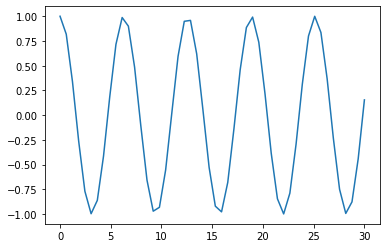

In [49]:
plt.plot(new_dset['x0'], new_dset['y0'])

In [36]:
MC.snapshot()

{'functions': {},
 'submodules': {},
 '__class__': 'quantify.measurement.measurement_control.MeasurementControl',
 'parameters': {'IDN': {'value': None,
   'ts': None,
   'raw_value': None,
   '__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'MC_IDN',
   'label': 'IDN',
   'unit': '',
   'inter_delay': 0,
   'instrument': 'quantify.measurement.measurement_control.MeasurementControl',
   'instrument_name': 'MC',
   'post_delay': 0,
   'name': 'IDN',
   'vals': '<Anything>'},
  'datadir': {'value': '',
   'ts': '2020-04-24 23:07:16',
   'raw_value': '',
   '__class__': 'qcodes.instrument.parameter.ManualParameter',
   'full_name': 'MC_datadir',
   'label': 'datadir',
   'unit': '',
   'inter_delay': 0,
   'instrument': 'quantify.measurement.measurement_control.MeasurementControl',
   'instrument_name': 'MC',
   'post_delay': 0,
   'name': 'datadir',
   'vals': '<Strings>'},
  'setables': {'value': <qcodes.instrument.parameter.ManualParameter: p0 at 4848886864>,
   't

In [37]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 50)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 0.0 0.6122 1.224 1.837 ... 28.16 28.78 29.39 30.0
    y0       (dim_0) float64 1.0 0.8184 0.3394 -0.2628 ... -0.877 -0.4416 0.1543
Attributes:
    tuid:      20200424-231655-157fb8
    snapshot:  {'functions': {}, 'submodules': {}, '__class__': 'quantify.mea...

In [39]:
dset.attrs['snapshot']

{'functions': {},
 'submodules': {},
 '__class__': 'quantify.measurement.measurement_control.MeasurementControl',
 'parameters': {'IDN': {'value': None,
   'ts': None,
   'raw_value': None,
   '__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'MC_IDN',
   'label': 'IDN',
   'unit': '',
   'inter_delay': 0,
   'instrument': 'quantify.measurement.measurement_control.MeasurementControl',
   'instrument_name': 'MC',
   'post_delay': 0,
   'name': 'IDN',
   'vals': '<Anything>'},
  'datadir': {'value': '',
   'ts': '2020-04-24 23:07:16',
   'raw_value': '',
   '__class__': 'qcodes.instrument.parameter.ManualParameter',
   'full_name': 'MC_datadir',
   'label': 'datadir',
   'unit': '',
   'inter_delay': 0,
   'instrument': 'quantify.measurement.measurement_control.MeasurementControl',
   'instrument_name': 'MC',
   'post_delay': 0,
   'name': 'datadir',
   'vals': '<Strings>'},
  'setables': {'value': <qcodes.instrument.parameter.ManualParameter: p0 at 4848886864>,
   't

In [29]:
dset.items

<bound method Mapping.items of <xarray.Dataset>
Dimensions:  (dim_0: 50)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 0.0 0.6122 1.224 1.837 ... 28.16 28.78 29.39 30.0
    y0       (dim_0) float64 1.0 0.8184 0.3394 -0.2628 ... -0.877 -0.4416 0.1543>

In [27]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 50)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 0.0 0.6122 1.224 1.837 ... 28.16 28.78 29.39 30.0
    y0       (dim_0) float64 1.0 0.8184 0.3394 -0.2628 ... -0.877 -0.4416 0.1543

In [ ]:
hasattr()